In [1]:
import os
from pathlib import Path
import time
import logging
import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import openai

from capstone.config import CapstoneConfig
from capstone.data_access import DataClass
from capstone.features import Features
from capstone.evaluation import CustomEvaluation
from capstone.utils.constants import (
    TEXT,
    TARGET,
    ORIGINAL_TEXT,
    SPLIT,
    DEVELOP,
    TEST
)

sns.set_style("darkgrid")
PARENT_PATH = Path(os.getcwd()).parent.absolute()
openai.api_key = os.getenv("OPENAI_API_KEY")

FORMAT = "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
logging.basicConfig(format=FORMAT, level=logging.INFO)

In [2]:
config = CapstoneConfig()
config.CURRENT_PATH = PARENT_PATH

data = DataClass(config)
df = data.build()
df.head(3)

,Text,Standard mapping?
0,General Quality System Requirements […] Manage...,"[quality management, quality planning]"
1,General Quality System Requirements […] Manage...,[quality management]
2,General Quality System Requirements […] Manage...,[quality management]


In [3]:
features = Features(config)
df_features = features.build(df)

2022-11-30 10:59:45,441 - capstone.utils.utils - INFO - func:clean took: 3.14 sec
2022-11-30 10:59:46,130 - capstone.utils.utils - INFO - func:fit took: 3.83 sec
2022-11-30 10:59:47,894 - capstone.utils.utils - INFO - func:clean took: 1.76 sec
2022-11-30 10:59:48,144 - capstone.utils.utils - INFO - func:transform took: 2.01 sec
2022-11-30 10:59:48,144 - capstone.utils.utils - INFO - func:fit_transform took: 5.84 sec
2022-11-30 10:59:48,337 - capstone.utils.utils - INFO - func:clean took: 0.19 sec
2022-11-30 10:59:48,365 - capstone.utils.utils - INFO - func:transform took: 0.22 sec
2022-11-30 10:59:48,401 - capstone.utils.utils - INFO - func:build took: 6.12 sec


In [4]:
labels_to_numeric_map = {
    features.mlb.classes_[i]: i+1 for i in range(len(features.mlb.classes_))
}

labels_to_numeric_map

{'audit inspection': 1,
 'calibration': 2,
 'capa': 3,
 'change controls': 4,
 'clinical research': 5,
 'controled substances': 6,
 'csv': 7,
 'data management': 8,
 'design controls': 9,
 'documentation management': 10,
 'facilities': 11,
 'handling': 12,
 'identification and traceability': 13,
 'labeling and packaging operations': 14,
 'laboratory controls': 15,
 'material and product controls': 16,
 'md product cybersecurity': 17,
 'medical device post market surveillance': 18,
 'nc': 19,
 'new product quality planning': 20,
 'non clinical research': 21,
 'packaging operations': 22,
 'process & packaging validation': 23,
 'product returns': 24,
 'production process controls': 25,
 'purchasing controls': 26,
 'qrb': 27,
 'qsmr': 28,
 'quality management': 29,
 'quality planning': 30,
 'rca': 31,
 'risk management': 32,
 'samd': 33,
 'stability programs': 34,
 'storage and distribution': 35,
 'training': 36,
 'udi and serialization': 37,
 'utilities and equipment': 38,
 'vigilance': 3

In [5]:
numeric_to_labels_map = {}
for label in labels_to_numeric_map:
    numeric_to_labels_map[labels_to_numeric_map[label]] = label

numeric_to_labels_map

{1: 'audit inspection',
 2: 'calibration',
 3: 'capa',
 4: 'change controls',
 5: 'clinical research',
 6: 'controled substances',
 7: 'csv',
 8: 'data management',
 9: 'design controls',
 10: 'documentation management',
 11: 'facilities',
 12: 'handling',
 13: 'identification and traceability',
 14: 'labeling and packaging operations',
 15: 'laboratory controls',
 16: 'material and product controls',
 17: 'md product cybersecurity',
 18: 'medical device post market surveillance',
 19: 'nc',
 20: 'new product quality planning',
 21: 'non clinical research',
 22: 'packaging operations',
 23: 'process & packaging validation',
 24: 'product returns',
 25: 'production process controls',
 26: 'purchasing controls',
 27: 'qrb',
 28: 'qsmr',
 29: 'quality management',
 30: 'quality planning',
 31: 'rca',
 32: 'risk management',
 33: 'samd',
 34: 'stability programs',
 35: 'storage and distribution',
 36: 'training',
 37: 'udi and serialization',
 38: 'utilities and equipment',
 39: 'vigilance

In [6]:
PROMPT = "prompt"
COMPLETION = "completion"

df_features[PROMPT] = \
    df_features[ORIGINAL_TEXT] \
    .apply(lambda x: f"Text: {x}\n\n###\n\n")

df_features[COMPLETION] = \
    df_features[TARGET] \
    .apply(lambda x: [str(labels_to_numeric_map[y]) for y in x]) \
    .apply(lambda x: ", ".join(x)) \
    .apply(lambda x: f" {x} END")

In [7]:
dev = df_features[df_features[SPLIT].isin([DEVELOP])].copy()
dev.reset_index(drop=True, inplace=True)
Y_dev = dev[features.mlb.classes_].copy()

test = df_features[df_features[SPLIT].isin([TEST])].copy()
test.reset_index(drop=True, inplace=True)
Y_test = test[features.mlb.classes_].copy()

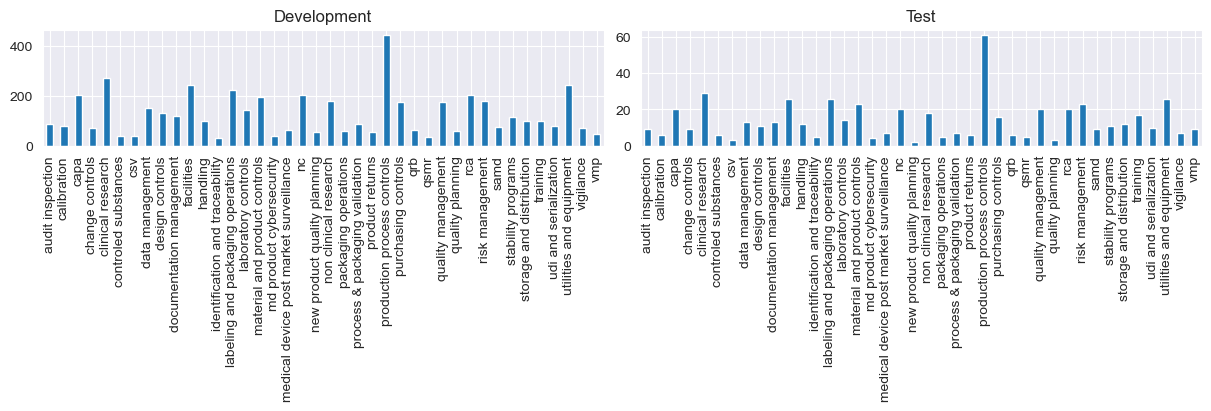

In [8]:
# plt.figure(figsize=(6, 3))
fig, ax = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)
Y_dev.sum(axis=0).plot.bar(ax=ax[0])
Y_test.sum(axis=0).plot.bar(ax=ax[1])
ax[0].set_title("Development")
ax[1].set_title("Test");

In [9]:
train, val, _, _ = train_test_split(
    dev, dev[features.mlb.classes_].to_numpy(), test_size=.1, shuffle=True, random_state=128
)
train.reset_index(drop=True, inplace=True)
val.reset_index(drop=True, inplace=True)

Y_train = train[features.mlb.classes_].copy()
Y_val = val[features.mlb.classes_].copy()

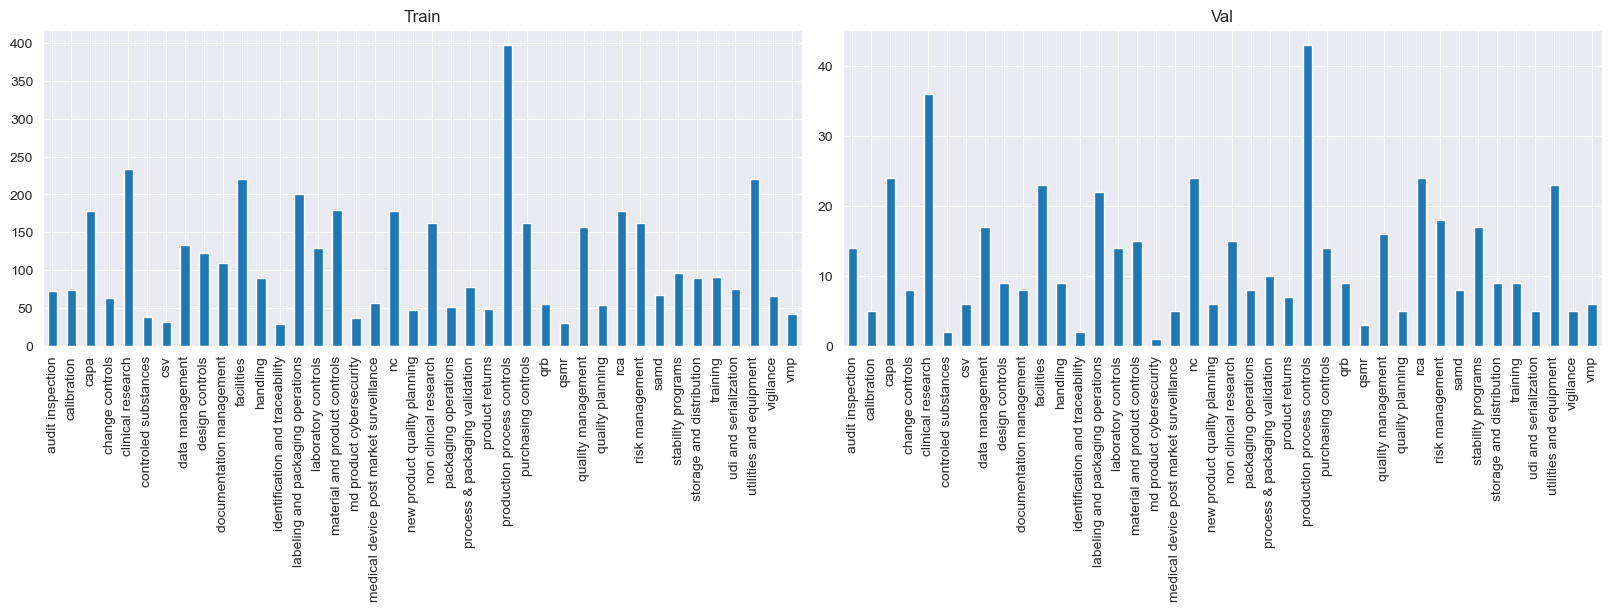

In [10]:
# plt.figure(figsize=(6, 3))
fig, ax = plt.subplots(1, 2, figsize=(16, 6), constrained_layout=True)
Y_train.sum(axis=0).plot.bar(ax=ax[0])
Y_val.sum(axis=0).plot.bar(ax=ax[1])
ax[0].set_title("Train")
ax[1].set_title("Val");

In [11]:
train_ft = train[[PROMPT, COMPLETION]].copy()
val_ft = val[[PROMPT, COMPLETION]].copy()

In [13]:
train_ft.to_json(os.path.join(data.data_path, "ft_training.jsonl"), orient="records", lines=True, force_ascii=False)
val_ft.to_json(os.path.join(data.data_path, "ft_validation.jsonl"), orient="records", lines=True, force_ascii=False)


In [13]:
MODEL = "ada:ft-columbia-university:multi-label-2022-11-25-02-23-00"

In [15]:
# function to predict the categories from the test set; input relevant engine name
def get_category(text):
    time.sleep(5)                                               # trottle for rate limit
    response = openai.Completion.create(
            prompt=f"{text}",
            temperature=0,
            top_p=1,
            max_tokens=100,
            stop="END",
            frequency_penalty=0,
            presence_penalty=0,
            model=MODEL,  #"RegulatoryStandardsClassifier2" is the ft-engine in our internal Azure OpenAI, use text-davinci-002 on the free tier. 
            logprobs=2
            #logit_bias={"584":100, "33306":100}
        )
    #return (response["choices"][0])
    return (response["choices"][0]["text"])

In [16]:
PREDICTION = "prediction"

test[PREDICTION] = test[PROMPT].apply(get_category)

2022-11-25 12:59:31,614 - openai - INFO - message='Request to OpenAI API' method=post path=https://api.openai.com/v1/completions
2022-11-25 12:59:32,006 - openai - INFO - message='OpenAI API response' path=https://api.openai.com/v1/completions processing_ms=166 request_id=2c59d9b888a4ce2d13686830bc78a1bd response_code=200
2022-11-25 12:59:37,013 - openai - INFO - message='Request to OpenAI API' method=post path=https://api.openai.com/v1/completions
2022-11-25 12:59:37,149 - openai - INFO - message='OpenAI API response' path=https://api.openai.com/v1/completions processing_ms=78 request_id=5785d95d6b610d5c52d33943b4782327 response_code=200
2022-11-25 12:59:42,156 - openai - INFO - message='Request to OpenAI API' method=post path=https://api.openai.com/v1/completions
2022-11-25 12:59:42,349 - openai - INFO - message='OpenAI API response' path=https://api.openai.com/v1/completions processing_ms=135 request_id=564abcf78d9ca6d4f1e8fe42893d58c5 response_code=200
2022-11-25 12:59:47,352 - ope

In [63]:
test[COMPLETION]

0              21 END
1               5 END
2          10, 25 END
3              40 END
4       3, 19, 31 END
            ...      
379            14 END
380            25 END
381         1, 25 END
382             5 END
383        11, 38 END
Name: completion, Length: 384, dtype: object

In [64]:
CORRECTED = "corrected_prediction"

test[CORRECTED] = \
    test[PREDICTION] \
    .apply(lambda x: x.split(",")) \
    .apply(lambda x: [y.strip() for y in x]) \
    .apply(lambda x: [numeric_to_labels_map[int(y)] for y in x])

In [65]:
test[CORRECTED]

0                              [non clinical research]
1                                  [clinical research]
2      [documentation management, laboratory controls]
3                     [process & packaging validation]
4                                      [capa, nc, rca]
                            ...                       
379                [labeling and packaging operations]
380                      [production process controls]
381                                  [design controls]
382                                [clinical research]
383              [facilities, utilities and equipment]
Name: corrected_prediction, Length: 384, dtype: object

In [66]:
y_pred = features.mlb.transform(test[CORRECTED])

In [67]:
eval = CustomEvaluation()

In [68]:
eval.compute_sample_wise_metrics(y_true=Y_test.to_numpy(), y_pred=y_pred)


Hamming Loss    0.015039
Accuracy        0.721354
Precision       0.846354
Recall          0.816174
F1 Score        0.816694
F2 Score        0.812894
dtype: float64

In [43]:
eval.compute_label_wise_metrics(
    y_true=Y_test.to_numpy(),
    y_pred=y_pred,
    labels=features.mlb.classes_,
    dev_samples=Y_dev.to_numpy().sum(axis=0).tolist()
)

,Precision,Recall,F1 Score,F2 Score,Development Samples,Test Samples
audit inspection,0.857143,0.666667,0.750000,0.697674,86,9
calibration,0.800000,0.666667,0.727273,0.689655,78,6
capa,0.800000,0.800000,0.800000,0.800000,202,20
change controls,0.777778,0.777778,0.777778,0.777778,71,9
clinical research,0.900000,0.931034,0.915254,0.924658,269,29
controled substances,1.000000,0.833333,0.909091,0.862069,40,6
csv,0.200000,0.333333,0.250000,0.294118,37,3
data management,0.764706,1.000000,0.866667,0.942029,150,13
design controls,0.666667,0.909091,0.769231,0.847458,132,11
documentation management,0.800000,0.615385,0.695652,0.645161,117,13
